In [24]:
import numpy as np
import scipy.ndimage
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## set directory of telescope aperture and list contents

In [25]:
telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
print telap_dir
print("Contents:")
os.listdir(telap_dir)

/Users/neil/STScI/SCDA/Apertures/JPL/offset_masks
Contents:


['._cross_spiders_1000pix_10.0cm_offset.fits',
 '._cross_spiders_1000pix_2.5cm_offset.fits',
 '._cross_spiders_2000pix_10.0cm_offset.fits',
 '._cross_spiders_2000pix_2.5cm_offset.fits',
 '._hex1_1000pix_offset.fits',
 '._hex1_2000pix_offset.fits',
 '._hex2_1000pix_offset.fits',
 '._hex2_2000pix_offset.fits',
 '._hex3_1000pix_offset.fits',
 '._hex3_2000pix_offset.fits',
 '._hex4_1000pix_offset.fits',
 '._hex4_2000pix_offset.fits',
 '._keystone24_1000pix_offset.fits',
 '._keystone24_2000pix_offset.fits',
 '._offset_y_spiders_60deg_1000pix_10.0cm_offset.fits',
 '._offset_y_spiders_60deg_1000pix_2.5cm_offset.fits',
 '._offset_y_spiders_60deg_2000pix_10.0cm_offset.fits',
 '._offset_y_spiders_60deg_2000pix_2.5cm_offset.fits',
 '._piewedge12_1000pix_offset.fits',
 '._piewedge12_2000pix_offset.fits',
 '._piewedge8_1000pix_offset.fits',
 '._piewedge8_2000pix_offset.fits',
 '._t_spiders_1000pix_10.0cm_offset.fits',
 '._t_spiders_1000pix_2.5cm_offset.fits',
 '._t_spiders_2000pix_10.0cm_offset.fit

## Load an aperture and a secondary obstruction, plot the product

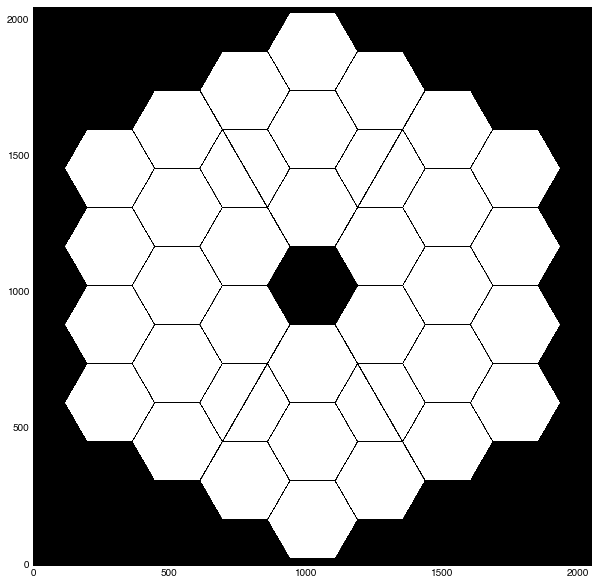

In [17]:
telap_fname = os.path.join(telap_dir, "hex3_2000pix_offset.fits")
secobs_fname = os.path.join(telap_dir, "x_spiders_2000pix_2.5cm_offset.fits")
telap_hdulist = fits.open(telap_fname, "readonly")
telap_orig = telap_hdulist[0].data
telap_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()
telap_obs = telap_orig*secobs
plt.figure(figsize=(10,10))
#plt.imshow(telap_orig)
plt.imshow(telap_obs)

### Test the symmetry

In [18]:
L = telap_obs.shape[0]
telap_left = telap_obs[:,:L/2] # left half
telap_right = telap_obs[:,L/2:] # right half
telap_top = telap_obs[L/2:,:] # left half
telap_bot = telap_obs[:L/2,:] # right half
leftright_diff = telap_left - telap_right[:,::-1]
topbot_diff = telap_top - telap_bot[::-1,:]
max_abs_leftright_diff = np.max(np.abs(leftright_diff))
max_abs_topbot_diff = np.max(np.abs(topbot_diff))
print('Max absolute left-right difference = {:g}'.format(max_abs_leftright_diff))
print('Max absolute top-bottom difference = {:g}'.format(max_abs_topbot_diff))

Max absolute left-right difference = 1.62491e-05
Max absolute top-bottom difference = 4.06511e-05


<matplotlib.colorbar.Colorbar instance at 0x10305a680>

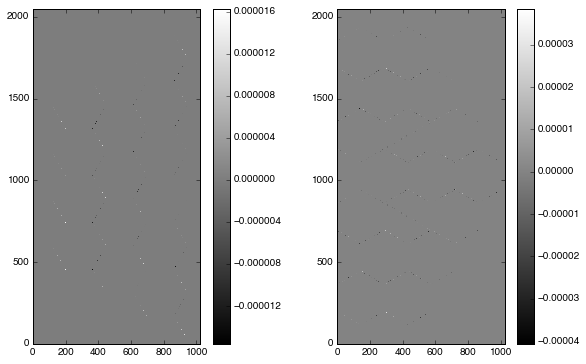

In [19]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(leftright_diff)
plt.colorbar()
plt.subplot(122)
plt.imshow(topbot_diff.T)
plt.colorbar()

## Bin to abritrary integer size, crop to quadrant

In [20]:
N_orig = 1000 # not 1024
N_fin = 300
scalefac = float(N_fin)/N_orig
telap_bin = scipy.ndimage.zoom(telap_obs, scalefac, order=1)
L_bin = telap_bin.shape[0]

In [21]:
telap_bin.shape

(614, 614)

In [22]:
telap_binquad = telap_bin[L_bin/2:L_bin/2+N_fin, L_bin/2:L_bin/2+N_fin]
telap_binquad.shape
# Check max value of outer row and outer column
print np.max(telap_binquad[-1,:])
print np.max(telap_binquad[:,-1])

0.375203915171
0.0


(-0.5, 299.5, -0.5, 299.5)

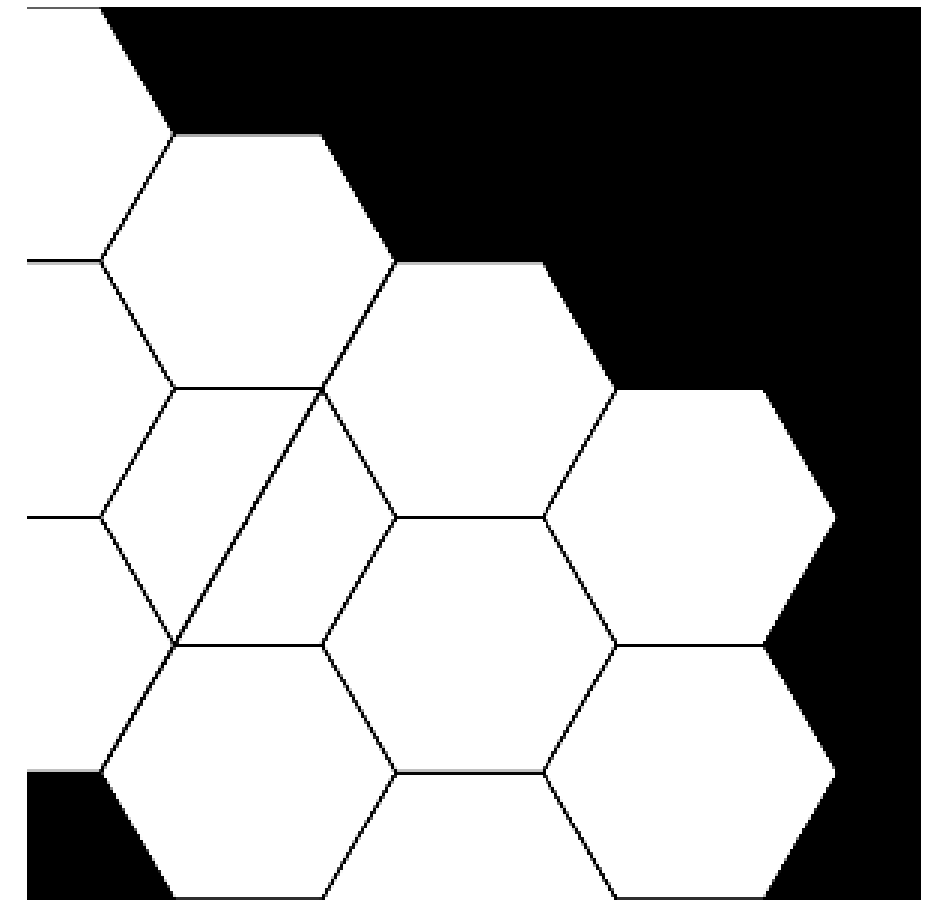

In [23]:
plt.figure(figsize=(16,16))
plt.imshow(telap_binquad)
plt.axis('off')

### Form new FITS filename and write

In [11]:
binned_telap_dir = os.path.abspath("../Apertures/STscI")
if not os.path.exists(binned_telap_dir):
    os.mkdir(binned_telap_dir)
    print("created {:s} for recentered, binned aperture arrays".format(binned_telap_dir))
else:
    print("Destination {:s} already exists".format(binned_telap_dir))

Destination /Users/neil/STScI/SCDA/Apertures/STscI already exists


In [12]:
telap_fname_tail = os.path.basename(telap_fname)
print telap_fname_tail
telap_label = telap_fname_tail.split("_")[0]
print telap_label
telap_label
telap_rcbq_fname = os.path.join(binned_telap_dir, "{:s}_quart_N{:04d}.fits".format(telap_label, N_fin))
print telap_rcbq_fname

hex3_2000pix_offset.fits
hex3
/Users/neil/STScI/SCDA/Apertures/STscI/hex3_quart_N0300.fits


In [14]:
telap_rcbq_hdu = fits.PrimaryHDU(telap_binquad)
telap_rcbq_hdu.writeto(telap_binquad_fname, clobber=True)